In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [5]:
# === 1. ODB GLODAP API fetch ===
cruise = "21OR19910626" # OR1_287 in 1991
glodap_url = "https://ecodata.odb.ntu.edu.tw/glodap/v2/2023/"
glodap_params = {
    "cruise": cruise,
    "append": "temperature,salinity,oxygen"
}
resp_glodap = requests.get(glodap_url, params=glodap_params)
resp_glodap.raise_for_status()
glodap_df = pd.DataFrame(resp_glodap.json())

In [6]:
print(glodap_df.head())

       expocode station  region  cast_number  year  month  latitude  \
0  21OR19910626     1.0       8            1  1991      6    21.912   
1  21OR19910626     9.0       8            1  1991      6    21.750   
2  21OR19910626     9.0       8            1  1991      6    21.750   
3  21OR19910626     9.0       8            1  1991      6    21.750   
4  21OR19910626     9.0       8            1  1991      6    21.750   

   longitude  bottomdepth  maxsampdepth  bottle  pressure  depth  \
0     120.89        276.0         131.0    12.0       0.0    0.0   
1     122.00       4000.0         995.0    10.0     350.0  348.0   
2     122.00       4000.0         995.0     9.0     550.0  546.0   
3     122.00       4000.0         995.0     8.0     699.0  693.0   
4     122.00       4000.0         995.0     7.0     850.0  843.0   

               datetime                                                doi  \
0  1991-06-26T15:04:00Z  https://doi.org/10.3334/cdiac/otg.pacifica_21o...   
1  1991-

In [ ]:
# === 2. Compute bounding box with 0.25 degree buffer ===
buffer = 0.25
lon0 = glodap_df["longitude"].min() - buffer
lon1 = glodap_df["longitude"].max() + buffer
lat0 = glodap_df["latitude"].min() - buffer
lat1 = glodap_df["latitude"].max() + buffer
print(f"Bounding box: ({lon0}, {lat0}), ({lon1}, {lat1})") 

Bounding box: (120.64, 21.498), (129.25, 22.162)


In [96]:
# === 3. ODB WOA23 API fetch ===
woa_url = "https://eco.odb.ntu.edu.tw/api/woa23"
# Finer grid for temperature/salinity
woa_params_ts = {
    "lon0": lon0, "lon1": lon1,
    "lat0": lat0, "lat1": lat1,
    "dep0": 0, "dep1": 10000,
    "parameter": "temperature,salinity",
    "grid": 0.25,
    "time_period": 0,
    "append": "an"
}
# Coarser grid for oxygen
woa_params_o2 = {
    "lon0": lon0, "lon1": lon1,
    "lat0": lat0, "lat1": lat1,
    "dep0": 0, "dep1": 10000,
    "parameter": "oxygen",
    "grid": 1,
    "time_period": 0,
    "append": "an"
}
resp_woa_ts = requests.get(woa_url, params=woa_params_ts)
resp_woa_ts.raise_for_status()
woa_ts_df = pd.DataFrame(resp_woa_ts.json())

resp_woa_o2 = requests.get(woa_url, params=woa_params_o2)
resp_woa_o2.raise_for_status()
woa_o2_df = pd.DataFrame(resp_woa_o2.json())


In [97]:
print(woa_ts_df.head())
woa_ts_df.shape[0]

       lon     lat  depth time_period  salinity_an  temperature_an
0  120.625  21.375    0.0           0    34.213490       27.226610
1  120.875  21.375    0.0           0    34.274113       27.254610
2  121.125  21.375    0.0           0    34.331600       27.261791
3  121.375  21.375    0.0           0    34.385700       27.249310
4  121.625  21.375    0.0           0    34.434212       27.222809


14688

In [98]:
print(woa_o2_df.head())
woa_o2_df.shape[0]

     lon   lat  depth time_period   oxygen_an
0  120.5  21.5    0.0           0  202.689224
1  121.5  21.5    0.0           0  202.203903
2  122.5  21.5    0.0           0  201.562378
3  123.5  21.5    0.0           0  202.162308
4  124.5  21.5    0.0           0  202.827942


2040

In [99]:
# Outer join to preserve all points from different resolution grids
woa_df = pd.merge(woa_ts_df, woa_o2_df, on=["lon", "lat", "depth", "time_period"], how="outer")


In [100]:
woa_df[woa_df.oxygen_an.notnull()]


,lon,lat,depth,time_period,salinity_an,temperature_an,oxygen_an
0,120.5,21.5,0.0,0,NaN,NaN,202.689224
1,120.5,21.5,5.0,0,NaN,NaN,201.918747
2,120.5,21.5,10.0,0,NaN,NaN,201.036728
3,120.5,21.5,15.0,0,NaN,NaN,200.326538
4,120.5,21.5,20.0,0,NaN,NaN,199.183456
...,...,...,...,...,...,...,...
16721,129.5,22.5,4900.0,0,NaN,NaN,157.000183
16722,129.5,22.5,5000.0,0,NaN,NaN,158.200089
16723,129.5,22.5,5100.0,0,NaN,NaN,160.135742
16724,129.5,22.5,5200.0,0,NaN,NaN,160.793610


In [101]:
# === 4. ODB CTD API fetch ===
ctd_url = "https://ecodata.odb.ntu.edu.tw/api/ctd"
ctd_params = {
    "lon0": lon0, "lon1": lon1,
    "lat0": lat0, "lat1": lat1,
    "dep0": 0, "dep1": 10000,
    "mode": 0,
    "append": "temperature,salinity,oxygen"
}
resp_ctd = requests.get(ctd_url, params=ctd_params)
resp_ctd.raise_for_status()
ctd_df = pd.DataFrame(resp_ctd.json())

In [102]:
print(ctd_df.head())
ctd_df.shape[0]

   longitude  latitude time_period  depth  temperature  salinity   oxygen
0     120.75      21.5           0      1       28.412    33.865  200.976
1     120.75      21.5           0    294       12.831    34.487  139.471
2     120.75      21.5           0     13       28.077    33.969  196.270
3     120.75      21.5           0    153       19.941    34.750  169.857
4     120.75      21.5           0      2       28.408    33.836  209.751


114687

In [ ]:
# Just used for checking the salinity data (at lon around 128 - 130)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(ctd_df[(ctd_df['depth']>=400) & (ctd_df['depth']<=1200) & (ctd_df['longitude']>=128) & (ctd_df['longitude']<128.5)][['longitude','latitude','depth','temperature','salinity','oxygen']])

        longitude  latitude  depth  temperature  salinity  oxygen
108178      128.0     21.75    606        8.967    33.884     NaN
108182      128.0     21.75    607        8.941    33.879     NaN
108186      128.0     21.75    608        8.922    33.879     NaN
108190      128.0     21.75    609        8.905    33.878     NaN
108194      128.0     21.75    610        8.876    33.877     NaN
108198      128.0     21.75    611        8.855    33.875     NaN
108202      128.0     21.75    612        8.837    33.817     NaN
108206      128.0     21.75    613        8.810    33.874     NaN
108210      128.0     21.75    614        8.793    33.874     NaN
108214      128.0     21.75    615        8.741    33.871     NaN
108218      128.0     21.75    616        8.689    33.870     NaN
108222      128.0     21.75    617        8.662    33.868     NaN
108226      128.0     21.75    618        8.646    33.866     NaN
108230      128.0     21.75    619        8.625    33.866     NaN
108234    

In [130]:
# compared the corresponding data in GLODAP dataset
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(glodap_df[(glodap_df['depth']>=0) & (glodap_df['depth']<=1500) & (glodap_df['longitude']>=128) & (glodap_df['longitude']<=128.5)][['longitude','latitude','depth','temperature','salinity','oxygen']])

     longitude  latitude   depth  temperature  salinity   oxygen
154      128.0     21.75     0.0       29.817    34.730  201.780
155      128.0     21.75    50.0       25.487    34.758  218.410
156      128.0     21.75   149.0       21.063    34.930  207.290
157      128.0     21.75   346.0       16.074    34.717  202.730
158      128.0     21.75   542.0       10.253    34.285  159.790
208      128.0     21.75   695.0        6.180    34.160  108.970
209      128.0     21.75   890.0        4.288    34.311   61.370
210      128.0     21.75  1089.0        3.593    34.452   67.450
211      128.0     21.75  1287.0        3.033    34.508   78.945
212      128.0     21.75  1486.0        2.660    34.566   98.800
215      128.5     21.75     0.0       30.101    34.736  205.010
216      128.5     21.75    50.0       26.723    34.713  222.110
217      128.5     21.75   149.0       21.134    34.929  207.290
218      128.5     21.75   349.0       16.130    34.721  205.960
219      128.5     21.75 

In [ ]:
# === 5. Shared Plotting Functions ===
def plot_profile_average2(df, api_name, param_keys, param_names, units, lon_col, lat_col, max_depth=2000):
    fig, axs = plt.subplots(3, 1, figsize=(8, 14), constrained_layout=True)
    for i, param in enumerate(param_keys):
        df_subset = df[[lon_col, lat_col, 'depth', param]]
        df_clean = df_subset[df_subset['depth'] <= max_depth]
        df_grouped = df_clean.groupby([lon_col,'depth'])[param].mean().reset_index()

        # Use pivot to construct full longitude-depth matrix
        pivot_table = df_grouped.pivot(index='depth', columns=lon_col, values=param)
        pivot_table = pivot_table.sort_index().sort_index(axis=1)  # ensure depth and lon sorted

        X, Y = np.meshgrid(pivot_table.columns.values, pivot_table.index.values)
        Z = pivot_table.values

        # Use pcolormesh which handles NaN values for sparse/gridded data better than contourf
        # pcm = axs[i].pcolormesh(X, Y, Z, cmap='coolwarm', shading='auto')
        levels = 128 if 'temperature' in param.lower() or 'oxygen' in param.lower() else 32
        cs = axs[i].contourf(X, Y, Z, cmap='coolwarm', levels=levels)
        cbar = fig.colorbar(cs, ax=axs[i]) # pcm
        cbar.set_label(f"{param_names[i]} ({units[i]})")
        axs[i].invert_yaxis()
        axs[i].set_ylabel('Depth (m)')
        axs[i].set_title(f"{param_names[i]} Profile")

    axs[-1].set_xlabel('Longitude (°E)')
    xticks = np.arange(int(X.min()), int(X.max()) + 1)
    for ax in axs:
        ax.set_xticks(xticks)

    fig.suptitle(f"Depth Profiles of ODB {api_name} API Data", fontsize=14)
    plt.show()
    
def plot_profile_average(df, api_name, param_keys, param_names, units, lon_col, lat_col, max_depth=2000):
    fig, axs = plt.subplots(3, 1, figsize=(8, 14), constrained_layout=True)
    for i, param in enumerate(param_keys):
        df_clean = df[[lon_col, lat_col, 'depth', param]].dropna()
        df_clean = df_clean[df_clean['depth']<=max_depth]
        df_grouped = df_clean.groupby([lon_col,'depth'])[param].mean().reset_index()
        lons = df_grouped[lon_col].values
        depths = df_grouped['depth'].values
        values = df_grouped[param].values
        unique_lons = np.unique(lons)
        unique_depths = np.unique(depths)
        x, y = np.meshgrid(unique_lons, unique_depths)
        mesh = np.full_like(x, np.nan, dtype=np.float32)
        for j in range(len(values)):
            lon_idx = np.where(unique_lons==lons[j])[0][0]
            depth_idx = np.where(unique_depths==depths[j])[0][0]
            mesh[depth_idx, lon_idx] = values[j]
        levels = 128 if 'temperature' in param or 'oxygen' in param else 32
        cs = axs[i].contourf(x, y, mesh, cmap='coolwarm', levels=levels)
        cbar = fig.colorbar(cs, ax=axs[i])
        cbar.set_label(f"{param_names[i]} ({units[i]})")
        axs[i].invert_yaxis()
        axs[i].set_ylabel('Depth (m)')
        axs[i].set_title(f"{param_names[i]} Profile")

    axs[-1].set_xlabel('Longitude (°E)')
    xticks = np.arange(int(lon0), int(lon1) + 1)
    for ax in axs:
        ax.set_xticks(xticks)
    
    fig.suptitle(f"Depth Profiles of ODB {api_name} API Data", fontsize=14)
    plt.show()

# === 6. Improved Scatter Plot for GLODAP ===
def plot_glodap_profiles(df, api_name, param_keys, param_names, units):
    fig, axs = plt.subplots(3, 1, figsize=(6, 12), constrained_layout=True)
    norm = Normalize(vmin=df['longitude'].min(), vmax=df['longitude'].max())
    cmap = plt.colormaps['viridis']

    for i, param in enumerate(param_keys):
        for station in df['station'].unique():
            sub = df[df['station'] == station].sort_values("depth")
            lon = sub["longitude"].mean()
            color = cmap(norm(lon))
            axs[i].plot(sub[param], sub["depth"], marker="o", linestyle="-", alpha=0.6, color=color)
        axs[i].invert_yaxis()
        axs[i].set_xlabel(f"{param_names[i]} ({units[i]})")
        axs[i].set_ylabel("Depth (m)")
        axs[i].set_title(f"{param_names[i]} Profile")
        axs[i].grid(True)
    fig.suptitle(f"OR1-287 Bottle Profiles of ODB {api_name} API Data", fontsize=14)
    plt.show()



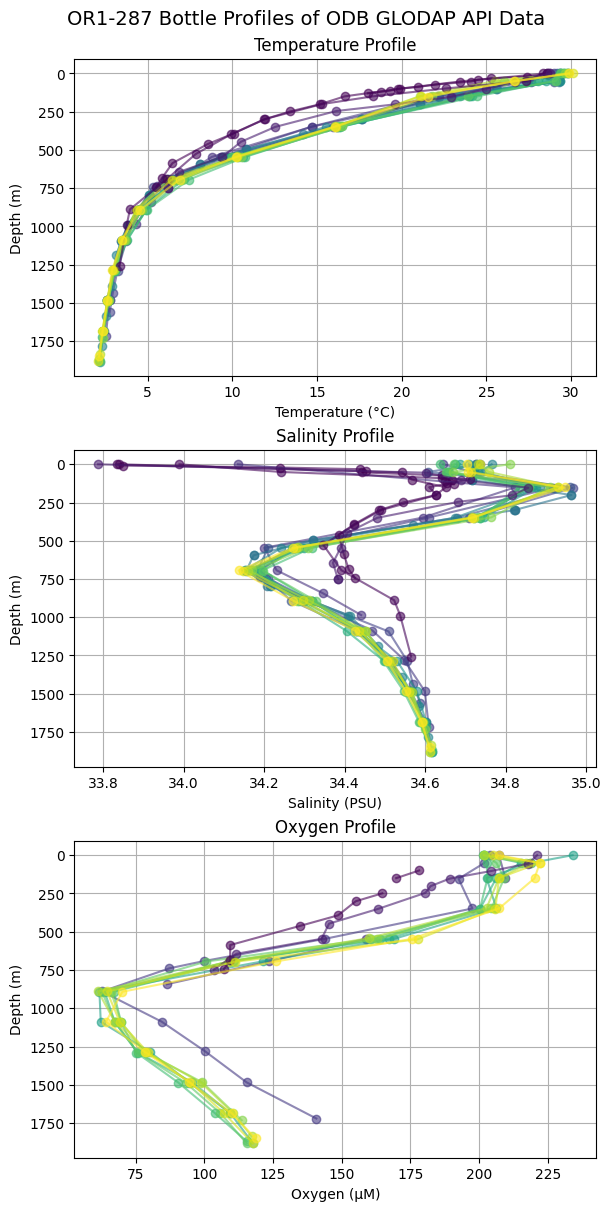

In [126]:
# === 6. Plot each API ===
plot_glodap_profiles(glodap_df, "GLODAP", ["temperature", "salinity", "oxygen"], ["Temperature", "Salinity", "Oxygen"], ["°C", "PSU", "μM"])



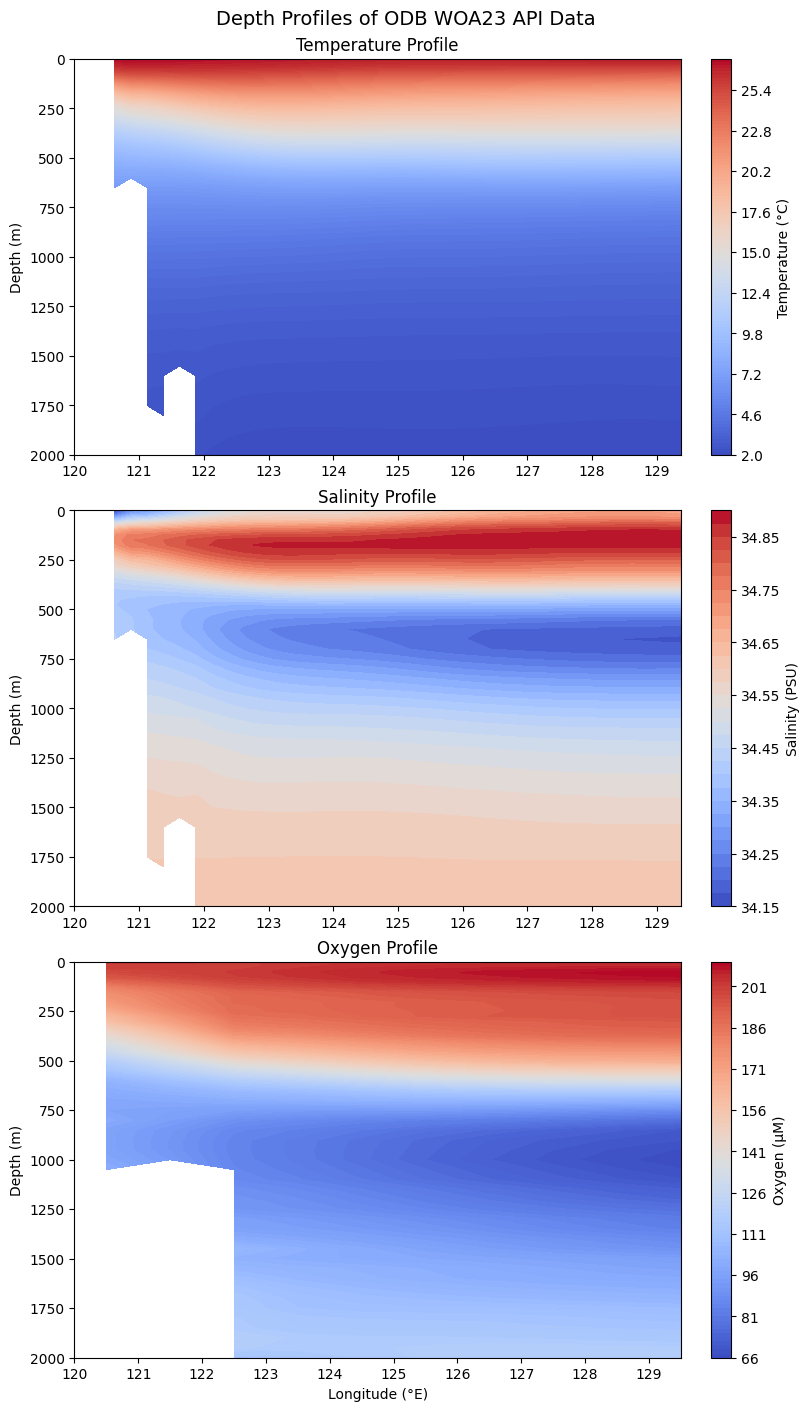

In [ ]:
plot_profile_average(woa_df, "WOA23", ["temperature_an", "salinity_an", "oxygen_an"], ["Temperature", "Salinity", "Oxygen"], ["°C", "PSU", "μM"], lon_col="lon", lat_col="lat", max_depth=2000)


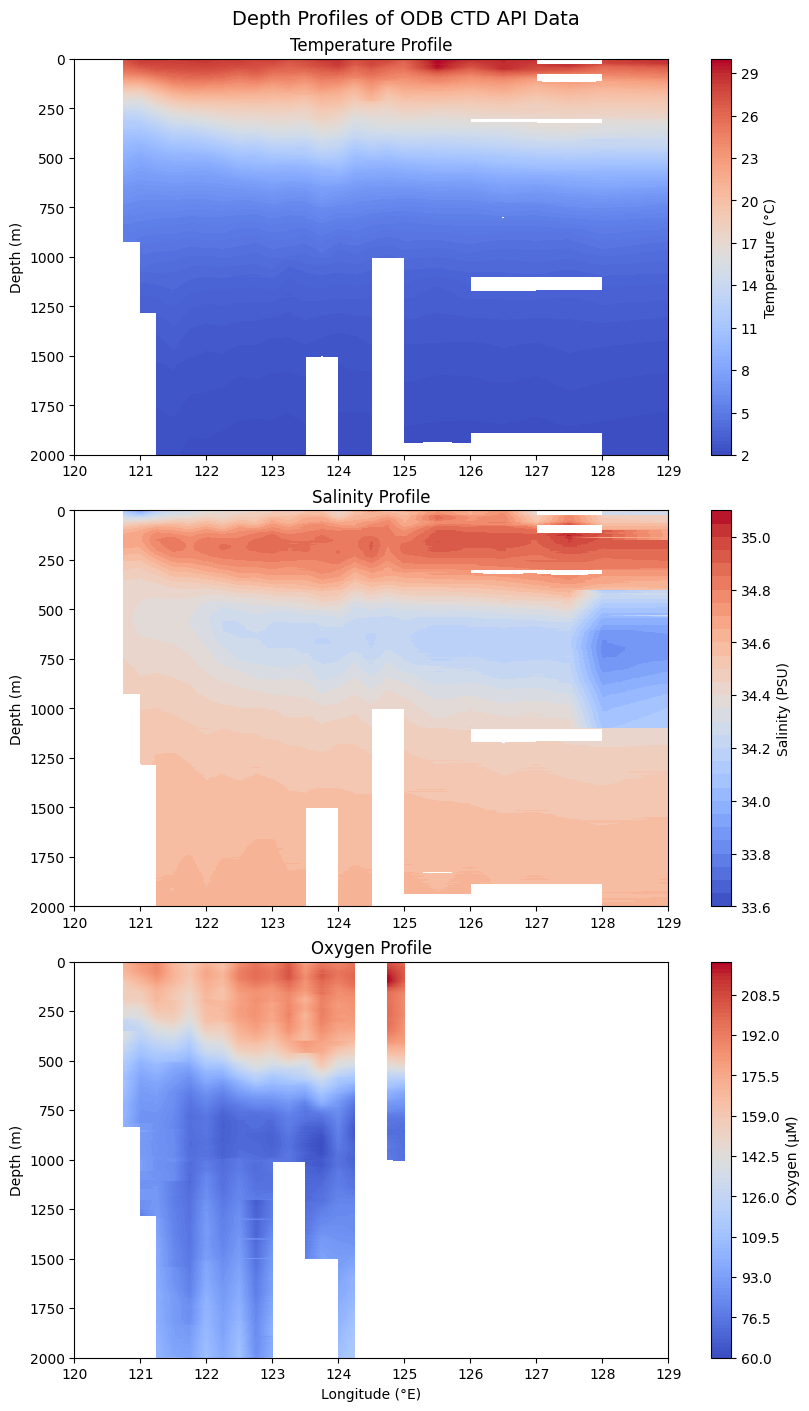

In [140]:
plot_profile_average2(ctd_df, "CTD", ["temperature", "salinity", "oxygen"], ["Temperature", "Salinity", "Oxygen"], ["°C", "PSU", "μM"], lon_col="longitude", lat_col="latitude", max_depth=2000)